In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import torch
import numpy 
import torchvision
from torchvision import transforms                                                                                                                                        
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt

import sys
sys.path.append("../../src/")
sys.path.append("../")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from utils.visualizations.visualize import concat_imgs, preprocess_arrays
from utils.function import recreate_image

# Model

In [5]:
# Model for original images
backbone = "vgg16"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)
# resume from model
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt, strict=False) 

Entire model.
Resume from model from exp: 037 at epoch 0


<All keys matched successfully>

# LRP module

## LRP

In [6]:
cd ../

/home/lincolnzjx/Desktop/Interpretation/jupyter


In [7]:
cd ../

/home/lincolnzjx/Desktop/Interpretation


In [8]:
cd extra/

/home/lincolnzjx/Desktop/Interpretation/extra


In [9]:
cd tutorial/

/home/lincolnzjx/Desktop/Interpretation/extra/tutorial


In [10]:
import utilss

In [11]:
# Model for LRP
model = torchvision.models.vgg16(pretrained=True) 
model.eval()
layers = list(model._modules['features']) + utilss.toconv(list(model._modules['classifier']))
for index, layer in enumerate(layers):
    print(index, layer)
# Image
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [12]:
def lrp(X, layers, L, selected_filters):
    """LRP
    Args:
        X: (3, 224, 224)
    """
    A = [X]+[None]*L
    for l in range(L): A[l+1] = layers[l].forward(A[l])
        
    scores = numpy.array(A[-1].data.view(-1))
    ind = numpy.argsort(-scores)
    
    _, output_channel, height, width = A[-1].shape
    input_channel, _, _, _ = A[-2].shape
    T = torch.zeros((input_channel, output_channel, height, width))
    T[:,selected_filter, :,:] = 1
    
    R = [None]*L + [(A[-1]*T).data]
    
    for l in range(1,L)[::-1]:
        
        A[l] = (A[l].data).requires_grad_(True)
    
        if isinstance(layers[l],torch.nn.MaxPool2d): 
            layers[l] = torch.nn.AvgPool2d(2)
    
        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            if l <= 16:       
#                 rho = lambda p: p + 0.25*p.clamp(min=0); 
                rho = lambda p: p.clamp(min=0); 
                incr = lambda z: z+1e-9
            if 17 <= l <= 30: 
#                 rho = lambda p: p;                       
                rho = lambda p: p.clamp(min=0); 
                incr = lambda z: z+1e-9
#                 incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            if l >= 31:       
#                 rho = lambda p: p;                       
                rho = lambda p: p.clamp(min=0); 
                incr = lambda z: z+1e-9
    
            z = incr(utilss.newlayer(layers[l],rho).forward(A[l]))  # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad                  # step 3
            R[l] = (A[l]*c).data                                   # step 4
            
        else:
            R[l] = R[l+1]
    
    # for i,l in enumerate([1]):
    #     utilss.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)
    
    A[0] = (A[0].data).requires_grad_(True)
    
    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)
    
    # z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
    # z -= utilss.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    # z -= utilss.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    
    
    layers[0].bias = torch.nn.Parameter(torch.zeros_like(layers[0].bias))
    z = layers[0].forward(A[0])                                     # step 1 (a)
    z -= utilss.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utilss.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    z += 1e-9 
    s = (R[1]/z).data                                                      # step 2
    
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4
    return R

## Main

In [19]:
def visualize_sel_fm(net, relevance_img, selected_layer, selected_filter, min_val, max_val): 
    """Visualize single feature map.
    Args:
        relevance_img: (3, w, h)
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    cm = plt.get_cmap("jet")
    opt_activation_maps = net.get_activation_maps(torch.FloatTensor(relevance_img).unsqueeze(dim=0).cuda(), selected_layer)
    opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
#     print(opt_activation_maps.max(), opt_activation_maps.min())
    opt_sel_feature_map -=min_val
    opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
    opt_sel_feature_map /= opt_sel_feature_map.max()
    opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
    #plt.imshow(cm(opt_sel_feature_map))
    opt_sel_feature_map = cm(opt_sel_feature_map)
    return opt_sel_feature_map

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
img = images[0]
img = img[0].permute((1,2,0)).numpy()
X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
R = lrp(X, layers, selected_layer+1, selected_filter)

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n01537544/n01537544_10133.JPEG").resize((224, 224))
ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG").resize((224, 224))
cm = plt.get_cmap("jet")
ori_arr = np.array(ori)
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
ori_nor = (torch.FloatTensor(ori_arr[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
ori_activation_maps = net.get_activation_maps(ori_nor.cuda(), selected_layer)
#ori_activation_maps = net.get_activation_maps(X.cuda(), selected_layer)
sel_feature_map = ori_activation_maps[0][0,selected_filter]
print(sel_feature_map.max(), sel_feature_map.min())
min_val = sel_feature_map.min()
print(selected_layer)
print(selected_filter)
print(min_val, max_val)
sel_feature_map -= min_val
max_val = sel_feature_map.max()
sel_feature_map /= max_val
plt.imshow(cm(sel_feature_map))
ori

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n01537544/n01537544_10133.JPEG").resize((224, 224))
# ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/950/L25F1/scale_total/n07747607_10061.png").resize((224, 224))
# ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/GBP/950/L25F1/scale_total/n07747607_10061.png").resize((224, 224))
# ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7013/149999/n07747607_10061.png").resize((224, 224))
# ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_1_16.png")
# ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_25_1.png")
# ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/mul_0_25_1.png")
ori = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_1_16.png")
cm = plt.get_cmap("jet")
ori_arr = np.array(ori)/255
ori_nor = (torch.FloatTensor(ori_arr[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

ori_activation_maps = net.get_activation_maps(ori_nor.cuda(), selected_layer)
# ori_activation_maps = net.get_activation_maps(X.cuda(), selected_layer)
sel_feature_map = ori_activation_maps[0][0,selected_filter]
print(sel_feature_map.max(), sel_feature_map.min())
# fm = sel_feature_map - min_val
# fm = 
fm = visualize_sel_fm(net, ori_nor[0], selected_layer, selected_filter, min_val, max_val)
# print(fm.shape)
# print(fm)
# print(min_val, max_val)
# fm = (255 * fm).astype(np.uint8)
plt.imshow(fm)
ori

### Standarization

In [94]:
def standalize(relevance, normalized, path):
    relevance = np.array(relevance)
    print(path)
    print(relevance.max(), relevance.min())
    normalized_img = X[0].numpy()
    relevance_img = relevance * normalized_img
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    Image.fromarray(new_image).save(path)
    return relevance_img

### Remove negative

In [93]:
def standalize_remove_negative(relevance, normalized, path):
    relevance = np.maximum(np.array(relevance), 0)
    print(path)
    print(relevance.max(), relevance.min())
    normalized_img = X[0].numpy()
    relevance_img = relevance * normalized_img
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    Image.fromarray(new_image).save(path)
    return relevance_img

### Scale

In [95]:
def scale_positive(relevance, normalized, path):
    relevance = np.maximum(np.array(relevance), 0.0)
    relevance -= relevance.min()
    relevance /= relevance.max()
    normalized_img = X[0].numpy()
    relevance_img = relevance * normalized_img
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    Image.fromarray(new_image).save(path)
    return relevance_img

### Total Scale

In [22]:
def scale_total(relevance, normalized, path):
    """Scale a single image totally.
    Args:
        relevance: [3, h, w]
        normalize: [3, h, w]
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    relevance = np.array(relevance)
    relevance /= np.max(np.abs(relevance))
    relevance_img = relevance * normalized[0]
#     relevance -= relevance.min()
#     relevance /= relevance.max()
#     print(relevance.max(), relevance.min())
#     print(relevance.shape)
#     print(normalized.shape)
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    if path != None:
        Image.fromarray(new_image).save(path)
    return relevance_img

### Scale abs

In [58]:
def scale_abs(relevance, normalized, path=None):
    relevance = np.array(relevance)
#     relevance -= relevance.min()
    relevance /= np.abs(relevance.max())
#     normalized_img = normalized.numpy()
    print(relevance.max(), relevance.min())
    relevance_img = relevance * normalized
#     _img
#     tmp = relevance_img.copy()
#     tmp -= tmp.min()
#     tmp /= tmp.max()
#     plt.imshow(tmp.transpose(1,2,0))
    print(relevance_img.shape)
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    print(new_image.max(), new_image.min())
    if path != None:
        Image.fromarray(new_image).save(path)
    plt.imshow(new_image)
    return relevance_img

# Main

In [20]:
def main(selected_layer=None, selected_filter=None, class_index=None):
    num_class = 30
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    train_transform = transforms.Compose([                                                                                                                                
        transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
        transforms.ToTensor(),                                                                                                                                            
           ])         
    trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                                 is_train=True, transform=train_transform)
    trainset.set_data([class_index], num_class)
    imgs_path = []                                                                                                                                                            
    images = []
    labels = []
    for img, label, img_path in trainset:                                                                                                                                     
        images.append(img.unsqueeze(0))                                                                                                                                       
        labels.append(label)                                                                                                                                                  
        imgs_path.append(img_path)  
    
    dirs = "/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/"
    dirs = os.path.join(dirs, str(class_index))
    
    # dir_name = "L{}F{}/standalize".format(selected_layer, selected_filter)
    # dir_name_fm = "L{}F{}/standalize_fm".format(selected_layer, selected_filter)
    # dir_name = "L{}F{}/standalize_nn".format(selected_layer, selected_filter)
    # dir_name_fm = "L{}F{}/standalize_nn_fm".format(selected_layer, selected_filter)
    # dir_name = "L{}F{}/scale_positive".format(selected_layer, selected_filter)
    # dir_name_fm = "L{}F{}/scale_positive_fm".format(selected_layer, selected_filter)
    dir_name = "L{}F{}/scale_total".format(selected_layer, selected_filter)
    dir_name_fm = "L{}F{}/scale_total_fm".format(selected_layer, selected_filter)
    
    dir_path = os.path.join(dirs, dir_name)
    dir_path_fm = os.path.join(dirs, dir_name_fm)
    
    os.makedirs(dir_path, exist_ok=True)
    os.makedirs(dir_path_fm, exist_ok=True)
    
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
    std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
    
    for img, img_path in zip(images, imgs_path):
        img = img[0].permute((1,2,0)).numpy()
        X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
        name = img_path.split("/")[-1].split(".")[0]
        
        # Ori
        ori_activation_maps = net.get_activation_maps(X.cuda(), selected_layer)
        sel_feature_map = ori_activation_maps[0][0,selected_filter]
        min_val = sel_feature_map.min()
        max_val = sel_feature_map.max()
        sel_feature_map -= sel_feature_map.min()
        sel_feature_map /= sel_feature_map.max()
        ori_fm_path = os.path.join(dir_path_fm, "ori_" + name +".png")
        cm = plt.get_cmap("jet")
    #     cm(sel_feature_map).save(ori_fm_path)
        sel_feature_map = cm(sel_feature_map)
        sel_feature_map = (sel_feature_map[:, :, :3] * 255).astype(np.uint8)
        Image.fromarray(sel_feature_map).save(ori_fm_path)
        
        # LRP 
        R = lrp(X, layers, selected_layer, selected_filter)
        path = os.path.join(dir_path, name+".png")
        fm_path = os.path.join(dir_path_fm, name+".png")
        
        # Standalize
        # relevance_img = standalize(R[0][0], X.numpy(), path)
        # fm = visualize_sel_fm(net, relevance_img.transpose(2,0,1), selected_layer, selected_filter, min_val, max_val)
        # fm = (255 * fm).astype(np.uint8)
        # Image.fromarray(fm).save(fm_path)
        
        # Standlize remove negative
        # relevance_img = standalize_remove_negative(R[0][0], X.numpy(), path)
        # fm = visualize_sel_fm(net, relevance_img.transpose(2,0,1), selected_layer, selected_filter, min_val, max_val)
        # fm = (255 * fm).astype(np.uint8)
        # Image.fromarray(fm).save(fm_path)
        
        # Scale positive
        # relevance_img = scale_positive(R[0][0], X.numpy(), path)
        # fm = visualize_sel_fm(net, relevance_img.transpose(2,0,1), selected_layer, selected_filter, min_val, max_val)
        # fm = (255 * fm).astype(np.uint8)
        # Image.fromarray(fm).save(fm_path)
        
        # Scale total
        relevance_img = scale_total(R[0][0], X.numpy(), path)
        fm = visualize_sel_fm(net, relevance_img, selected_layer, selected_filter, min_val, max_val)
        fm = (255 * fm).astype(np.uint8)
        Image.fromarray(fm).save(fm_path)

In [23]:
selected = [
    [1, 47],
    [1, 16],
    [3, 20],
    [6, 19],
    [8, 99],
    [11, 75],
    [15, 173],
    [18, 49],
    [22, 485],
    [25, 1],
    [29, 334]
]
class_indexes = [14, 950, 522]

for class_index in class_indexes:
    for selected_layer, selected_filter in selected:
        if selected_filter == 1 and class_index == 522:
            print(class_index, selected_layer, selected_filter)
            main(selected_layer, selected_filter, class_index)

522 25 1
Len of new dataset is :30


In [ ]:
num_class = 30
class_index = 522
selected_layer = 15
selected_filter = 173

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                             is_train=True, transform=train_transform)
trainset.set_data([class_index], num_class)
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

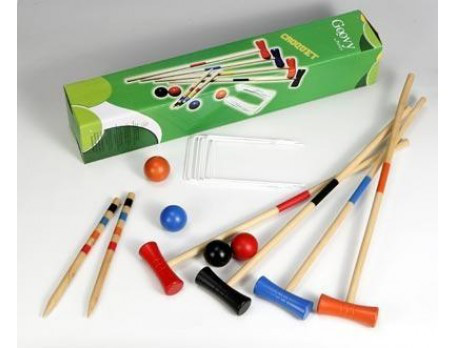

In [83]:
Image.open(img_path)

In [5]:
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

for img, img_path in zip(images, imgs_path):
    img = img[0].permute((1,2,0)).numpy()
    X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
    name = img_path.split("/")[-1].split(".")[0]
    
    # Ori
    ori_activation_maps = net.get_activation_maps(X.cuda(), selected_layer)
    sel_feature_map = ori_activation_maps[0][0,selected_filter]
    min_val = sel_feature_map.min()
    max_val = sel_feature_map.max()
    sel_feature_map -= sel_feature_map.min()
    sel_feature_map /= sel_feature_map.max()
    ori_fm_path = os.path.join(dir_path_fm, "ori_" + name +".png")
    cm = plt.get_cmap("jet")
    sel_feature_map = cm(sel_feature_map)
    sel_feature_map = (sel_feature_map[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(sel_feature_map).save(ori_fm_path)
    
    # LRP 
    dir_path_fm = "/home/lincolnzjx/Desktop/Interpretation/saved/pack/9008/fm"
    fm_path = os.path.join(dir_path_fm, name+".png")
    os.makedirs(dir_path_fm, exist_ok=True)
    opt_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/pack/9008/200000/"
    opt_img = Image.open(opt_dir+name+".png")
    opt_img = np.array(opt_img) / 255
    opt_img = opt_img.transpose(2,0,1)
    opt_img = (torch.FloatTensor(opt_img[numpy.newaxis]) - mean) / std
    fm = visualize_sel_fm(net, opt_img[0], selected_layer, selected_filter, min_val, max_val)
    fm = (255 * fm).astype(np.uint8)
    Image.fromarray(fm).save(fm_path)
    fm

NameError: name 'images' is not defined

min, max 0.0 43.037205


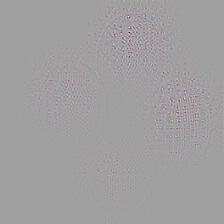

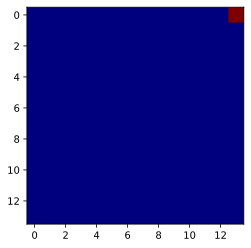

In [65]:
selected_layer = 25
selected_filter = 1

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG").resize((224, 224))

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10110.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10166.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10205.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10465.JPEG").resize((224, 224))

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n03134739/n03134739_10258.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n03134739/n03134739_10193.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n03134739/n03134739_10123.JPEG").resize((224, 224))
ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n03134739/n03134739_1008.JPEG").resize((224, 224))

cm = plt.get_cmap("jet")
ori_arr = np.array(ori)/255
ori_nor = (torch.FloatTensor(ori_arr[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
ori_activation_maps = net.get_activation_maps(ori_nor.cuda(), selected_layer)
sel_feature_map = ori_activation_maps[0][0,selected_filter]
min_val = sel_feature_map.min()
sel_feature_map -= min_val
max_val = sel_feature_map.max()
sel_feature_map /= max_val
# plt.imshow(cm(sel_feature_map))
print("min, max" ,min_val, max_val)

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7009/149999/n07747607_10061.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10061.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10166.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10110.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10061.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10166.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10465.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_15_173.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_2_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_11_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_25_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_3_20.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/9010/299999/n03134739_10258.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/9010/299999/n03134739_10193.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/9010/299999/n03134739_10123.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/9010/299999/n03134739_1008.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_1008.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_10123.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_10193.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_10258.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_1008.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_10123.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP/522/L25F1/scale_total/n03134739_10193.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/GBP/522/L25F1/scale_total/n03134739_10258.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/522/output/25_1/8.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/522/output/25_1/12.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/522/output/25_1/26.png").resize((224, 224))
img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/522/output/25_1/18.png").resize((224, 224))

img_arr = np.array(img)/255
X = (torch.FloatTensor(img_arr[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
fm = visualize_sel_fm(net, X[0], selected_layer, selected_filter, min_val, max_val)
plt.imshow(fm)
img

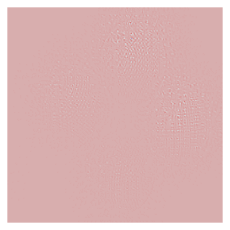

In [66]:
utilss.heatmap(X[0].numpy().sum(axis=0), 3, 3)

(array([7.0000e+00, 2.5000e+01, 1.7000e+02, 2.0000e+03, 4.6867e+04,
        1.0080e+03, 7.9000e+01, 1.5000e+01, 4.0000e+00, 1.0000e+00]),
 array([-3.6905847 , -2.7715974 , -1.8526102 , -0.93362296, -0.01463575,
         0.9043515 ,  1.8233387 ,  2.742326  ,  3.661313  ,  4.5803003 ,
         5.4992876 ], dtype=float32),
 <a list of 10 Patch objects>)

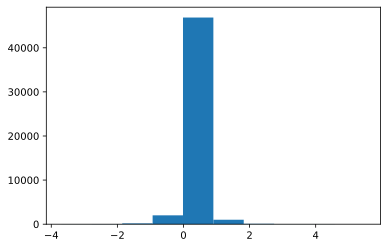

In [62]:
plt.hist(X[0].numpy().sum(axis=0).reshape(-1))

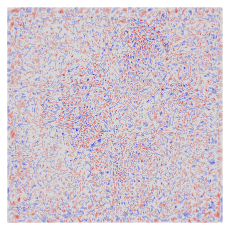

In [67]:
new_show = X[0].numpy().sum(axis=0)
# new_show = img.copy()
# new_show = img
# new_show[np.abs(new_show).max()*0.2 > new_show] = 0
new_show[np.abs(new_show) < 0.01] = 0
# new_show -= new_show.min()
# new_show /= new_show.max()
utilss.heatmap(new_show, 3, 3)

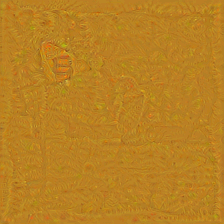

In [77]:
new_img = img.copy()
new_img -= new_img.min()
new_img /= new_img.max()
Image.fromarray((new_img * 255).astype(np.uint8))

In [108]:
def adjust_gamma(src, gamma=2.0):
    scale = float(np.iinfo(src.dtype).max - np.iinfo(src.dtype).min)
#     scale = src.max() - src.min()
    dst = ((src.astype(np.float32) / scale) ** gamma) * scale
    dst = np.clip(dst, 0, 255).astype(np.uint8)
    return dst

In [19]:
new_img = (img.copy() * 255).astype(np.uint8)
# dst = adjust_gamma(new_img, 1.2)
# Image.fromarray(dst)

In [2]:
import cv2

In [3]:
la = cv2.Laplacian(new_img, cv2.CV_16S, ksize=3)
result = cv2.convertScaleAbs(la)
cv2.imshow("result", result)

NameError: name 'new_img' is not defined

In [ ]:
plt.hist(X[0].numpy().sum(axis=0))